Importing Necessary Libraries

In [1]:
pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.2 which is incompatible.


In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt

import csv

Mounting google drive

In [3]:
keras.__version__

'3.0.2'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the metadata repository file

In [5]:

with open("/content/drive/MyDrive/Dataset/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

Configure the path for points and label directories, and global variables for model training.

In [6]:
#points_dir = "/content/drive/MyDrive/Dataset/points"
#labels_dir = "/content/drive/MyDrive/Dataset/points_label"
LABELS = metadata["Chair"]["lables"]
COLORS = metadata["Chair"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

In [7]:
print(LABELS)
print(COLORS)

['leg', 'arm', 'back', 'seat']
['blue', 'green', 'red', 'pink']


Construct point cloud data and labels from the individual PTS files

In [ ]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []


points_files = glob(os.path.join(points_dir, "*.pts"))

for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)


Saving the PCD and labels to a CSV file

In [ ]:
# Define the path where the CSV file will be saved
csv_labels_path = r'C:\Users\Iesa\Desktop\PCD\chair_all_labels.csv'

# Open the CSV file for writing
with open(csv_labels_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Write header to the CSV file
    csv_writer.writerow(['index', 'class_name'])

    # Write each index and class name as a row in the CSV file
    for index, class_names in enumerate(all_labels):
        for class_name in class_names:
            csv_writer.writerow([index, class_name])

print(f'CSV file for all_labels with index created at: {csv_labels_path}')

Functions for reconstructing the PCD and corresponding labels from CSV files

In [8]:
def reconstruct_data_from_csv(csv_file_path):
    """
    Reconstruct the point cloud data from a csv file. The csv file contains 4 attributes - index, x, y, z. For each object index,
    a nested array of (x, y, z) points is created. All the objects' PCD, is stored in another array - reconstructed_data.

    Returns an array of dim - (n x (m x 3))
    n - Number of objects
    m - number of points each object is composed of
    """

    # Initialize a list to store point clouds for each airplane index
    reconstructed_data = []

    # Read the CSV file
    with open(csv_file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)

        # Skip the header
        header = next(csv_reader)

        # Get the column indices
        object_index_col, x_col, y_col, z_col = 0, 1, 2, 3

        # Initialize variables to track the current airplane index and its data
        current_object_index = None
        current_object_data = []

        # Iterate through rows in the CSV file
        for row in csv_reader:
            object_index = int(row[object_index_col])
            point_coordinates = [float(row[x_col]), float(row[y_col]), float(row[z_col])]

            # Check if the airplane index changes
            if current_object_index is None:
                current_object_index = object_index

            if object_index != current_object_index:
                reconstructed_data.append(np.array(current_object_data))
                current_object_index = object_index
                current_object_data = []

            # Add the point and labels to the current airplane's data
            current_object_data.append(point_coordinates)

        # Add the last set of data to the list
        if current_object_data:
            reconstructed_data.append(np.array(current_object_data))

    return reconstructed_data

In [9]:
def reconstruct_labels_from_csv(csv_file_path):
    """
    Reconstruct the point cloud labels from a csv file. The csv file contains object label attributes - index, Label1, Label2,..., LabelM.
    The labels are stored in the One-Hot-Encoded form. A nested array of the one hot encoded points is created.
    All the objects' PCD Lables are stored in another array - reconstructed_labels_list.

    Returns an array of dim - (n x (m x M))
    n - Number of objects
    m - number of points each object is composed of
    M - number of classes each object has
    """

    # Initialize a list to store one-hot encoded labels for each airplane
    reconstructed_labels_list = []

    # Read the CSV file
    with open(csv_file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)

        # Skip the header
        header = next(csv_reader)

        # Get the column indices
        object_index_col = 0
        label_cols = [i for i in range(1, len(header))]  # Assuming labels start from column index 1

        # Initialize variables to track the current airplane index and its labels
        current_object_index = None
        current_object_labels = []

        # Iterate through rows in the CSV file
        for row in csv_reader:
            object_index = int(row[object_index_col])
            one_hot_labels = [int(float(row[label_col])) for label_col in label_cols]

            # Check if the airplane index changes
            if current_object_index is None:
                current_object_index = object_index

            if object_index != current_object_index:
                reconstructed_labels_list.append(np.array(current_object_labels, dtype=np.float32))
                current_object_index = object_index
                current_object_labels = []

            # Add the labels to the current airplane's labels
            current_object_labels.append(np.array(one_hot_labels, dtype=np.float32))

        # Add the last set of labels to the list
        if current_object_labels:
            reconstructed_labels_list.append(np.array(current_object_labels, dtype=np.float32))

    return reconstructed_labels_list

In [10]:
def reconstruct_all_labels(csv_labels_path):
    """
    Reconstructs the worded label data from a CSV file. Each class of a point in an object is stored as a nested array of
    strings representing their class labels. All the labels for each object is stored as an arrat.

    Returns a nested array of dim - n x m
    n - Number of objects
    m - Number of Points in each object
    """

    # Read the CSV file
    all_labels_reconstructed = []

    with open(csv_labels_path, 'r') as csvfile:
        csv_reader = csv.DictReader(csvfile)

        current_index = -1
        current_labels = []

        for row in csv_reader:
            index = int(row['index'])
            class_name = row['class_name']

            if index != current_index:
                if current_labels:
                    all_labels_reconstructed.append(current_labels)
                current_index = index
                current_labels = []

            current_labels.append(class_name)

        if current_labels:
            all_labels_reconstructed.append(current_labels)

    return all_labels_reconstructed

Reconstructing the PCD points and labels

In [12]:

csv_file_path = "/content/drive/MyDrive/Dataset/chair_points.csv"
point_clouds = reconstruct_data_from_csv(csv_file_path)

csv_file_path = "/content/drive/MyDrive/Dataset/chair_labels.csv"
point_cloud_labels = reconstruct_labels_from_csv(csv_file_path)

csv_file_path = "/content/drive/MyDrive/Dataset/chair_test_points.csv"
test_point_clouds = reconstruct_data_from_csv(csv_file_path)

csv_file_path = "/content/drive/MyDrive/Dataset/chair_all_labels.csv"
all_labels = reconstruct_all_labels(csv_file_path)

In [13]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[4241].shape: (2652, 3)
point_cloud_labels[4241].shape: (2652, 5)
all_labels[4241][0]: back 	point_cloud_labels[4241][0]: [0. 0. 1. 0. 0.] 

all_labels[4241][1]: back 	point_cloud_labels[4241][1]: [0. 0. 1. 0. 0.] 

all_labels[4241][2]: seat 	point_cloud_labels[4241][2]: [0. 0. 0. 1. 0.] 

all_labels[4241][3]: seat 	point_cloud_labels[4241][3]: [0. 0. 0. 1. 0.] 

all_labels[4241][4]: seat 	point_cloud_labels[4241][4]: [0. 0. 0. 1. 0.] 

point_clouds[4748].shape: (2652, 3)
point_cloud_labels[4748].shape: (2652, 5)
all_labels[4748][0]: back 	point_cloud_labels[4748][0]: [0. 0. 1. 0. 0.] 

all_labels[4748][1]: back 	point_cloud_labels[4748][1]: [0. 0. 1. 0. 0.] 

all_labels[4748][2]: back 	point_cloud_labels[4748][2]: [0. 0. 1. 0. 0.] 

all_labels[4748][3]: back 	point_cloud_labels[4748][3]: [0. 0. 1. 0. 0.] 

all_labels[4748][4]: back 	point_cloud_labels[4748][4]: [0. 0. 1. 0. 0.] 

point_clouds[616].shape: (2652, 3)
point_cloud_labels[616].shape: (2652, 5)
all_labels[616][0]

Function For visualizing Point Cloud Data

In [14]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


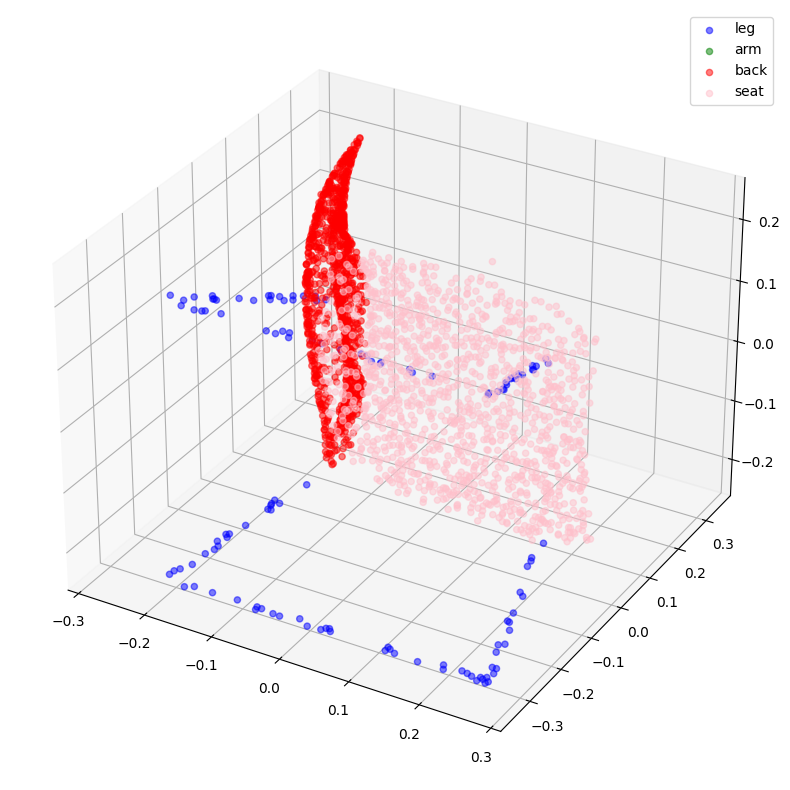

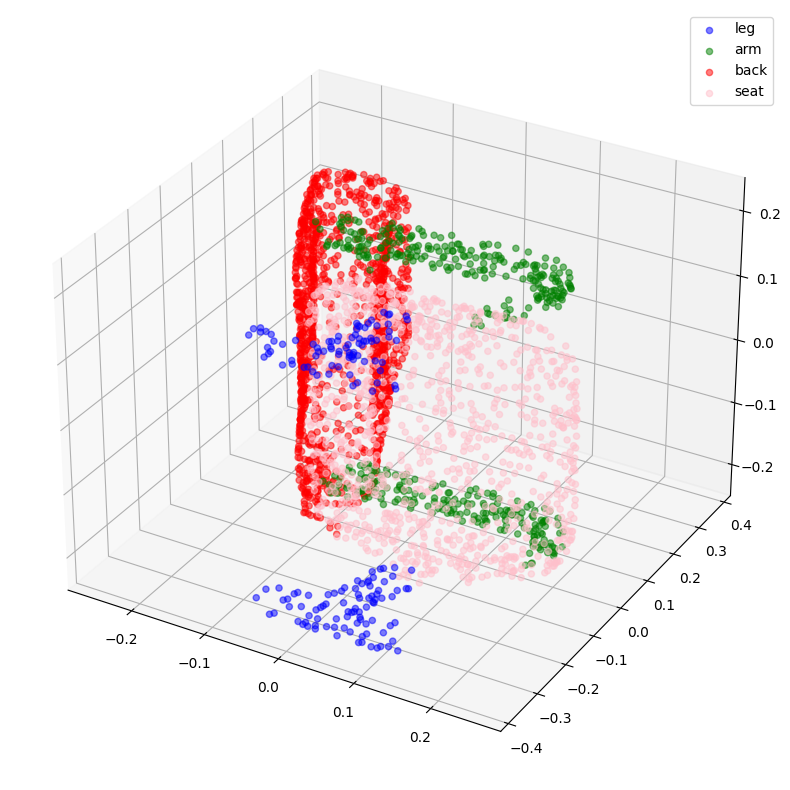

In [15]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

Data Pre-Processing - Random Sampling and Normalization

In [16]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 6024/6024 [00:18<00:00, 317.26it/s]


Creating TensorFlow augumented datasets and perfrom Train-Validation Split

In [17]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.001, 0.001, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 4819
Num train point cloud labels: 4819
Num val point clouds: 1205
Num val point cloud labels: 1205
Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float32, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float32, name=None))>


Defining The PointNet Mode

In [19]:
def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x, filters, name):
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

In [20]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = keras.ops.eye(num_features)

    def __call__(self, x):
        x = keras.ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = keras.ops.tensordot(x, x, axes=(2, 2))
        xxt = keras.ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return keras.ops.sum(self.l2reg * keras.ops.square(xxt - self.identity))

    def get_config(self):
        config = super().get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

In [21]:
def transformation_net(inputs, num_features, name):
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [22]:
def get_shape_segmentation_model(num_points, num_classes):
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = keras.ops.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

In [23]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 3)        │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │        256 │ input_layer[0][0]          │
│ (Conv1D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │        256 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │          0 │ input_transformation_bloc… │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │      8,320 │ input_transformation_bloc… │
│ (Conv1D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │        512 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │          0 │ input_transformation_bloc… │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │    132,096 │ input_transformation_bloc… │
│ (Conv1D)                  │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │      4,096 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │          0 │ input_transformation_bloc… │
│ (Activation)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ global_max_pooling1d      │ (None, 1024)           │          0 │ input_transformation_bloc… │
│ (GlobalMaxPooling1D)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │    524,800 │ global_max_pooling1d[0][0] │
│ (Dense)                   │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │      2,048 │ input_transformation_bloc… │
│ (BatchNormalization)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ input_transformation_

 Total params: 7,370,062 (28.11 MB)

 Trainable params: 7,356,110 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

Visualizing the Learning Rate of the Model

Steps per epoch: 150.
Total training steps: 9000.


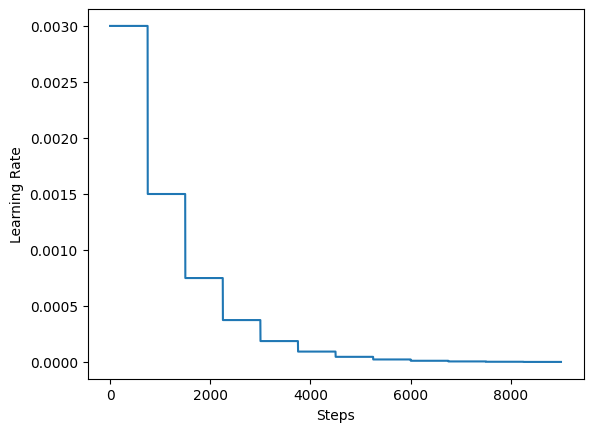

In [ ]:
steps_per_epoch = total_training_examples // BATCH_SIZE
total_training_steps = steps_per_epoch * EPOCHS
print(f"Steps per epoch: {steps_per_epoch}.")
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.003,
    decay_steps=steps_per_epoch * 5,
    decay_rate=0.5,
    staircase=True,
)

steps = range(total_training_steps)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Training the PointNet Model

In [ ]:
def run_experiment(epochs):
  with tf.device('/gpu:0'):
      segmentation_model = get_shape_segmentation_model(num_points, num_classes)
      segmentation_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
          loss=keras.losses.CategoricalCrossentropy(),
          metrics=["accuracy"],
      )

      checkpoint_filepath = "checkpoint.weights.h5"
      checkpoint_callback = keras.callbacks.ModelCheckpoint(
          checkpoint_filepath,
          monitor="val_loss",
          save_best_only=True,
          save_weights_only=True,
      )

      history = segmentation_model.fit(
          train_dataset,
          validation_data=val_dataset,
          epochs=epochs,
          callbacks=[checkpoint_callback],
      )

      segmentation_model.load_weights(checkpoint_filepath)
      return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 97s 423ms/step - accuracy: 0.4389 - loss: 37692.9570 - val_accuracy: 0.2830 - val_loss: 26608990.0000
Epoch 2/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 91s 229ms/step - accuracy: 0.6585 - loss: 395.7177 - val_accuracy: 0.4941 - val_loss: 9970398.0000
Epoch 3/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 234ms/step - accuracy: 0.6920 - loss: 282.5542 - val_accuracy: 0.3659 - val_loss: 16980528.0000
Epoch 4/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - accuracy: 0.7005 - loss: 232.3247 - val_accuracy: 0.3251 - val_loss: 50762600.0000
Epoch 5/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.7124 - loss: 219.6805 - val_accuracy: 0.3663 - val_loss: 12516237.0000
Epoch 6/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.7272 - loss: 208.1428 - val_accuracy: 0.2878 - val_loss: 37807.1055
Epoch 7/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 234ms/step - accuracy: 0.7346 - loss: 198.3372 - val_accuracy: 0.7428 - val_loss: 1550.4941
Epoch 8/60
151/151 ━━━━━━━

Visualize the Training Landscape

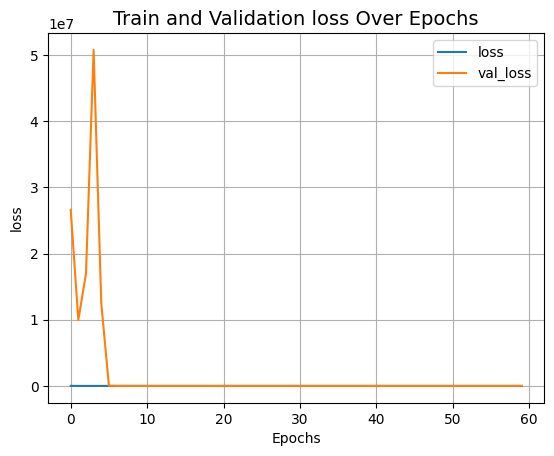

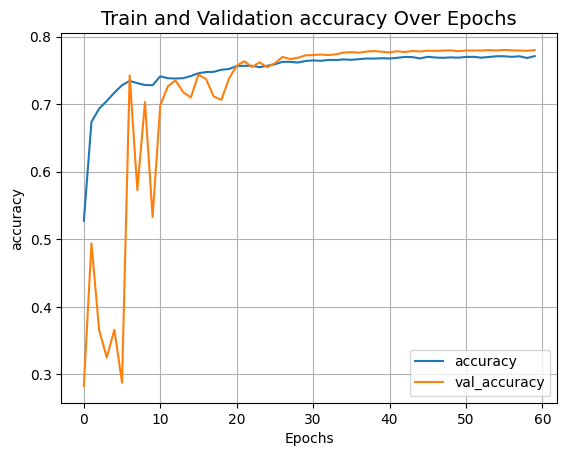

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [24]:
model = get_shape_segmentation_model(num_points, num_classes)
model.load_weights("/content/drive/MyDrive/Dataset/chair_checkpoint_64.weights.h5")

Perform part segmentaion for an object

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Validation prediction shape: (32, 1024, 5)
Index selected: 21


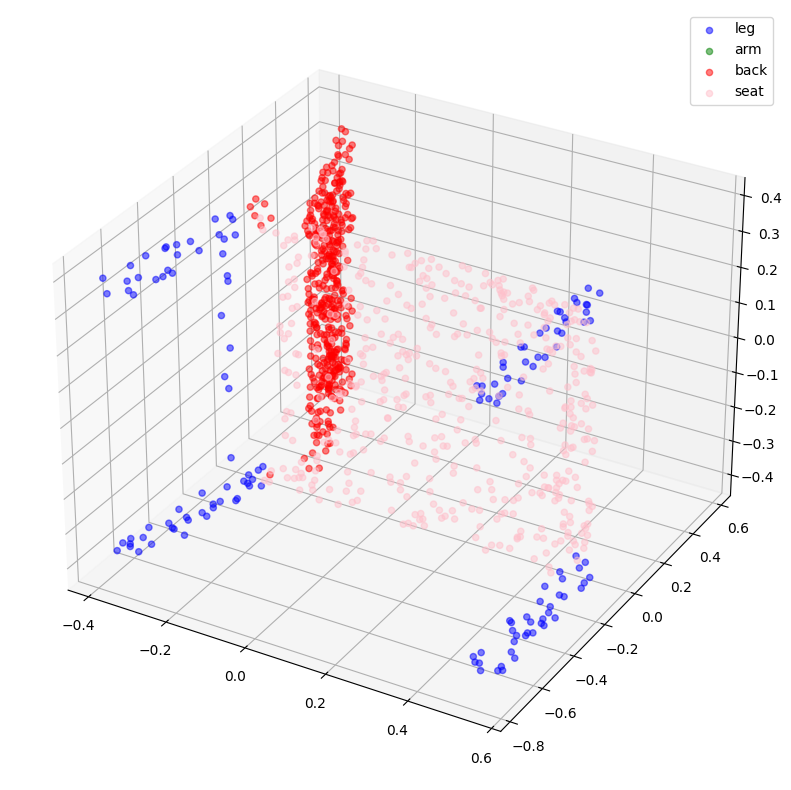

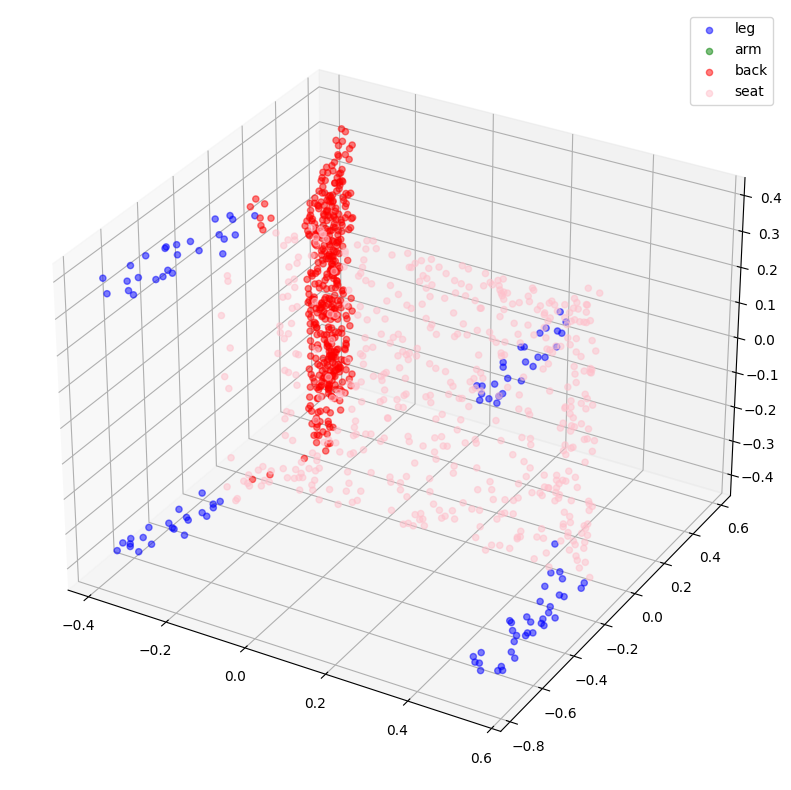

In [30]:
validation_batch = next(iter(val_dataset))
val_predictions = model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

In [26]:
# Initialize variables to store class-wise statistics
class_pixel_counts = np.zeros(num_classes)
class_correct_counts = np.zeros(num_classes)

# Evaluate the model on a new dataset
for images, masks_true in val_dataset:
    # Assuming the model predicts masks
    masks_pred = model.predict(images)

    # Convert masks to class labels (index of maximum value along the last axis)
    classes_true = np.argmax(masks_true, axis=-1)
    classes_pred = np.argmax(masks_pred, axis=-1)

    # Update counts for each class
    for class_idx in range(num_classes):
        class_mask_true = (classes_true == class_idx)
        class_mask_pred = (classes_pred == class_idx)

        class_pixel_counts[class_idx] += np.sum(class_mask_true)
        class_correct_counts[class_idx] += np.sum(class_mask_true & class_mask_pred)

# Calculate class-wise accuracy
class_accuracies = class_correct_counts / (class_pixel_counts + np.finfo(float).eps)

# Display or use class-wise accuracies as needed
for class_idx, accuracy in enumerate(class_accuracies):
    print(f"Class {class_idx} Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3